In [1]:
import numpy as np
import zipfile
import os
import PIL
import PIL.Image
import pandas as pd
import tensorflow as tf
from PIL import Image
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input

In [2]:
current_directory = os.getcwd()
print(current_directory)

C:\Users\USUARIO\.conda\envs\mlops\notebooks


In [3]:
import gdown

id_archivo = '1KLGwwnG1K1Nnuh6tEqabryZmDrqQrTmW'
url = f'https://drive.google.com/uc?export=download&id={id_archivo}'
output = 'C:/Users/USUARIO/.conda/envs/mlops/plantas.zip'
gdown.download(url, output, quiet=False)

Downloading...
From (original): https://drive.google.com/uc?export=download&id=1KLGwwnG1K1Nnuh6tEqabryZmDrqQrTmW
From (redirected): https://drive.google.com/uc?export=download&id=1KLGwwnG1K1Nnuh6tEqabryZmDrqQrTmW&confirm=t&uuid=daf8ffcc-30e9-463a-a0e9-162037aadc6f
To: C:\Users\USUARIO\.conda\envs\mlops\plantas.zip
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 28.4M/28.4M [00:14<00:00, 1.95MB/s]


'C:/Users/USUARIO/.conda/envs/mlops/plantas.zip'

In [4]:
#!unzip -q plantas.zip -d'C:/Users/USUARIO/.conda/envs/mlops/plantas'
archivo_zip = 'C:/Users/USUARIO/.conda/envs/mlops/plantas.zip'
directorio_destino = 'C:/Users/USUARIO/.conda/envs/mlops/plantas'

# Descomprimir el archivo zip
with zipfile.ZipFile(archivo_zip, 'r') as zip_ref:
    zip_ref.extractall(directorio_destino)

In [5]:
batch_size = 32
img_height = 224
img_width = 224

data_dir = 'C:/Users/USUARIO/.conda/envs/mlops/plantas'

In [6]:
id = 1
data_list = []

for (root, dirs, files) in os.walk(data_dir, topdown=True):
    if len(dirs) == 0:
        for file_ in files:
            data_list.append([root[len(data_dir) + 1:] + '/' + file_, root[len(data_dir) + 1:]])

data_train, data_val = train_test_split(data_list, test_size=0.2, shuffle=True, random_state=42)

df_train = pd.DataFrame(data=data_train, columns=['id', 'label'])
df_val = pd.DataFrame(data=data_val, columns=['id', 'label'])

In [7]:
df_val.head(10)

,id,label
0,Ruda/76.jpg,Ruda
1,Jengibre/108.jpg,Jengibre
2,Jazmin/450.jpg,Jazmin
3,Eucalipto/678.jpg,Eucalipto
4,Aloevera/24.jpg,Aloevera
5,Jengibre/84.jpg,Jengibre
6,Ruda/134.jpg,Ruda
7,Ruda/44.jpg,Ruda
8,Menta/688.jpg,Menta
9,Cilandro/248.jpg,Cilandro


In [8]:
df_train

,id,label
0,Aloevera/152.jpg,Aloevera
1,Eucalipto/644.jpg,Eucalipto
2,Menta/818.jpg,Menta
3,Ruda/96.jpg,Ruda
4,Eucalipto/674.jpg,Eucalipto
...,...,...
511,Aloevera/226.jpg,Aloevera
512,Aloevera/332.jpg,Aloevera
513,Eucalipto/634.jpg,Eucalipto
514,Jengibre/82.jpg,Jengibre


In [9]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1 / 255., horizontal_flip=True)
val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1 / 255.)

In [10]:
train_ds = train_datagen.flow_from_dataframe(
  df_train,
  directory=data_dir,
  x_col='id',
  y_col='label',
  seed=42,
  shuffle=True,
  target_size=(img_height, img_width),
  class_mode="categorical",
  batch_size=batch_size)

val_ds = val_datagen.flow_from_dataframe(
  df_val,
  directory=data_dir,
  x_col='id',
  y_col='label',
  target_size=(img_height, img_width),
  class_mode="categorical",
  batch_size=batch_size)

Found 516 validated image filenames belonging to 7 classes.
Found 130 validated image filenames belonging to 7 classes.


In [11]:
class_to_idx = train_ds.class_indices
class_to_idx

{'Aloevera': 0,
 'Cilandro': 1,
 'Eucalipto': 2,
 'Jazmin': 3,
 'Jengibre': 4,
 'Menta': 5,
 'Ruda': 6}

In [12]:
idx_to_class_list = [(value, key) for value, key in class_to_idx.items()]
idx_to_class = {}

for element in idx_to_class_list:
    idx_to_class[element[1]] = element[0]

idx_to_class

{0: 'Aloevera',
 1: 'Cilandro',
 2: 'Eucalipto',
 3: 'Jazmin',
 4: 'Jengibre',
 5: 'Menta',
 6: 'Ruda'}

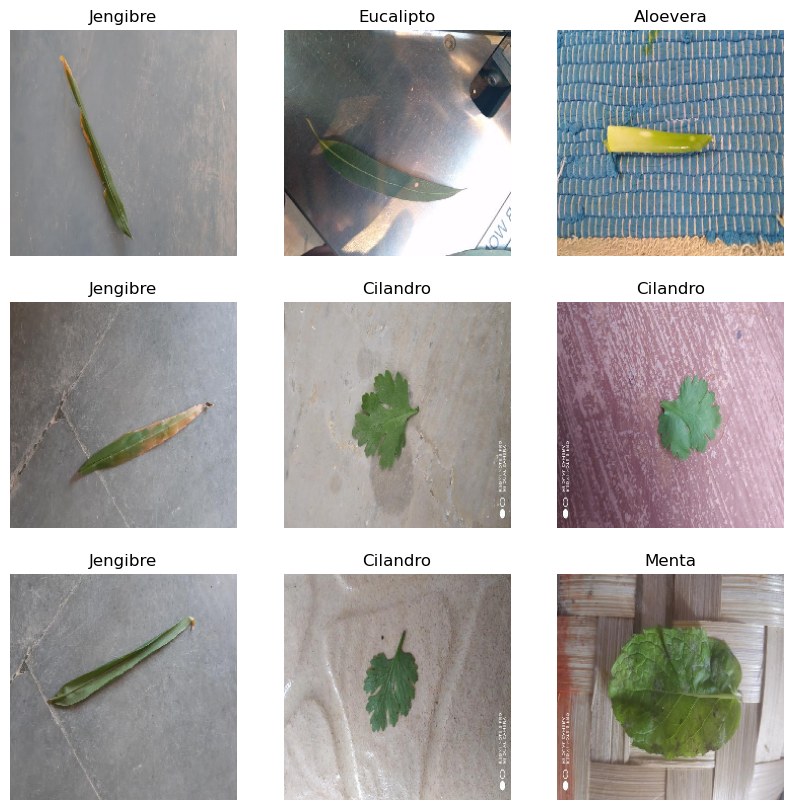

In [13]:
plt.figure(figsize=(10, 10))

for i in range(9):
    images, labels = train_ds.next()
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])
    plt.title(idx_to_class[np.argmax(labels[i])])
    plt.axis("off")

In [14]:
num_classes = len(idx_to_class)

model = tf.keras.Sequential([
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(64, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(128, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),

  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(num_classes, activation='softmax')
])

In [15]:
vgg16 = tf.keras.applications.VGG16(input_shape=(img_height, img_width, 3), include_top=False, weights='imagenet')

vgg16.trainable = False

model = tf.keras.Sequential([
  vgg16,
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(num_classes, activation='softmax')
])

In [16]:
model.compile(optimizer=tf.keras.optimizers.Adam(0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [17]:
model.fit(train_ds, validation_data = val_ds, epochs = 5)

Epoch 1/5


17/17 [==============================] - 167s 10s/step - loss: 1.8459 - accuracy: 0.3062 - val_loss: 1.2425 - val_accuracy: 0.6538
Epoch 2/5
17/17 [==============================] - 184s 11s/step - loss: 1.1231 - accuracy: 0.6008 - val_loss: 0.8932 - val_accuracy: 0.7538
Epoch 3/5
17/17 [==============================] - 197s 12s/step - loss: 0.7948 - accuracy: 0.7519 - val_loss: 0.6018 - val_accuracy: 0.8692
Epoch 4/5
17/17 [==============================] - 198s 12s/step - loss: 0.5956 - accuracy: 0.8178 - val_loss: 0.4846 - val_accuracy: 0.9154
Epoch 5/5
17/17 [==============================] - 183s 11s/step - loss: 0.4837 - accuracy: 0.8508 - val_loss: 0.3892 - val_accuracy: 0.9385


1/1 [==============================] - 1s 969ms/step


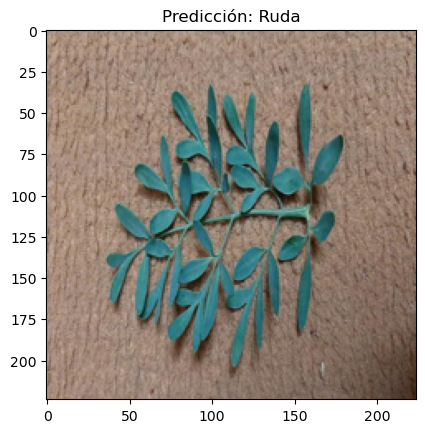

In [18]:
def predict_image(model, img_path, class_labels):
    # Carga la imagen
    img = Image.open(img_path)
    img = img.resize((224, 224))  # Ajusta el tamaño según lo necesario

    # Preprocesa la imagen
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)

    # Predice las probabilidades de clase
    preds = model.predict(x)

    # Obtiene la etiqueta correspondiente
    predicted_label = class_labels[np.argmax(preds)]

    # Muestra la imagen y la etiqueta predicha
    plt.imshow(img)
    plt.title(f"Predicción: {predicted_label}")
    plt.show()

# Ejemplo de uso
img_path = "C:/Users/USUARIO/.conda/envs/mlops/plantas/Ruda/14.jpg"
class_labels = ["Aloevera", "Cilandro", "Eucalipto", "Jazmin", "Jengibre", "Menta", "Ruda"]
predict_image(model, img_path, class_labels)

In [19]:
!mkdir -p saved_model
model.save('saved_model/model')

Ya existe el subdirectorio o el archivo -p.
Error mientras se procesaba: -p.
Ya existe el subdirectorio o el archivo saved_model.
Error mientras se procesaba: saved_model.


INFO:tensorflow:Assets written to: saved_model/model\assets


INFO:tensorflow:Assets written to: saved_model/model\assets
